# Imports

In [7]:
import imutils
from imutils.video import FileVideoStream
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')    
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf

from utils.app_utils import FPS, WebcamVideoStream
from multiprocessing import Queue, Pool
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Env setup

In [8]:
# This is needed to display the images.
%matplotlib inline

PATH_TO_MODEL = "ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb"
PATH_TO_LABELS = "object_detection/data/mscoco_label_map.pbtxt"

NUM_CLASSES = 90

# Load label map

In [9]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                           use_display_name = True)
category_index = label_map_util.create_category_index(categories)

# Detection sections ....

In [10]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [11]:
def worker(input_q, output_q):
    # Load a (frozen) Tensorflow model into memory.
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

        sess = tf.Session(graph=detection_graph)

    fps = FPS().start()
    while True:
        fps.update()
        frame = input_q.get()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        output_q.put(detect_objects(frame_rgb, sess, detection_graph))

    fps.stop()
    sess.close()

[INFO] starting video file thread...


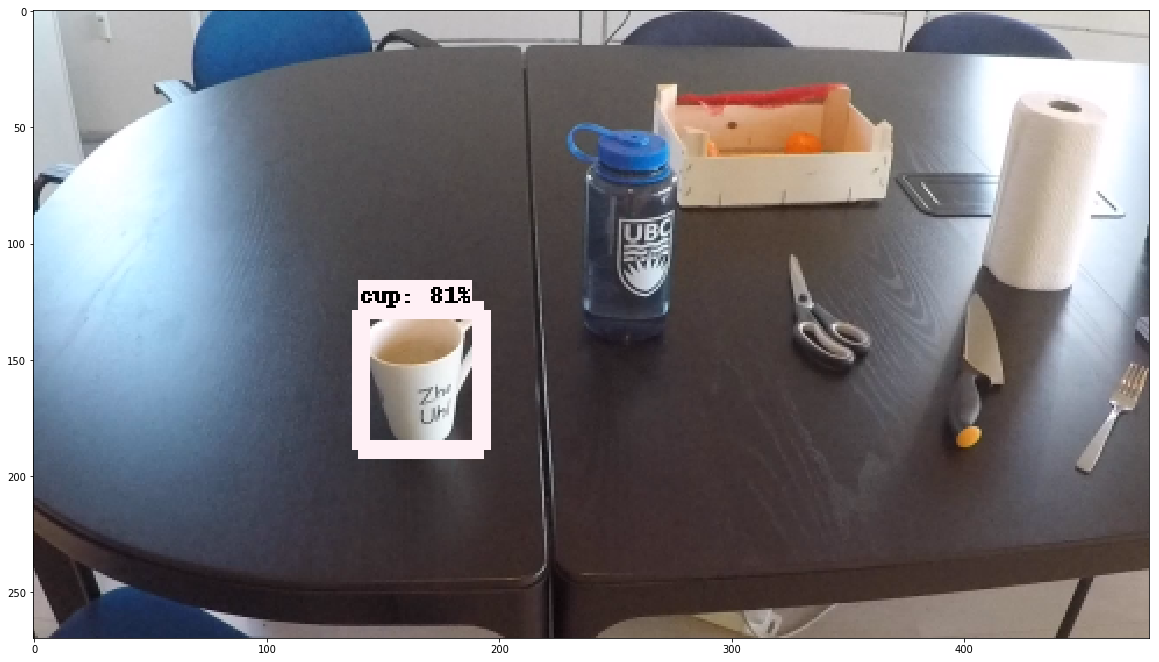

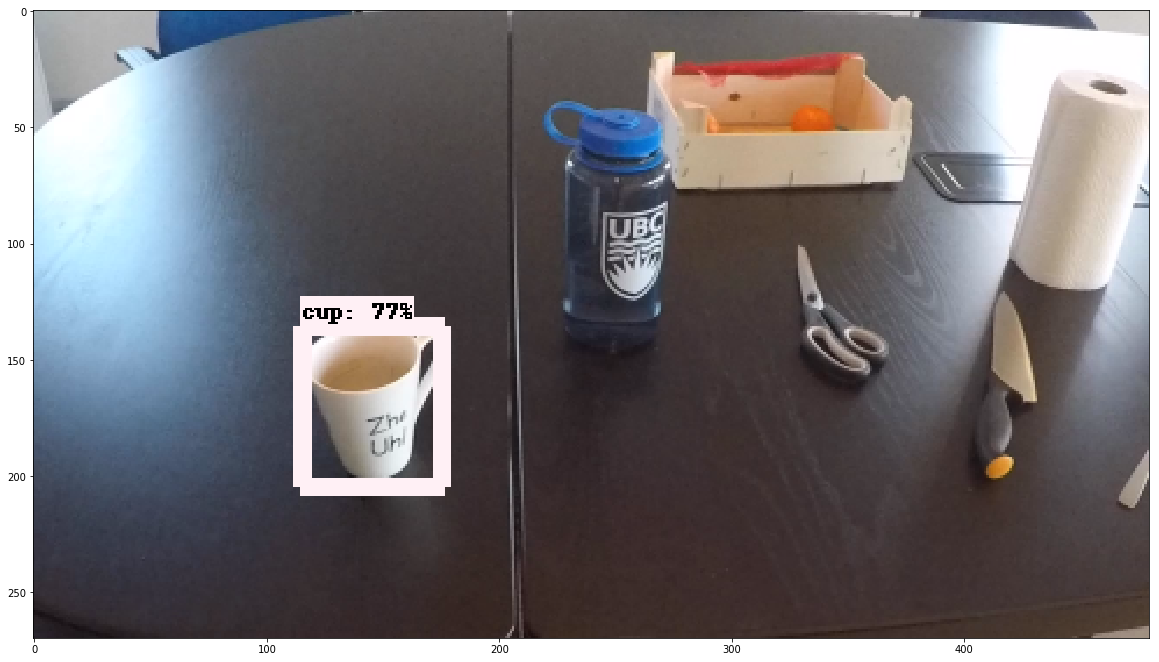

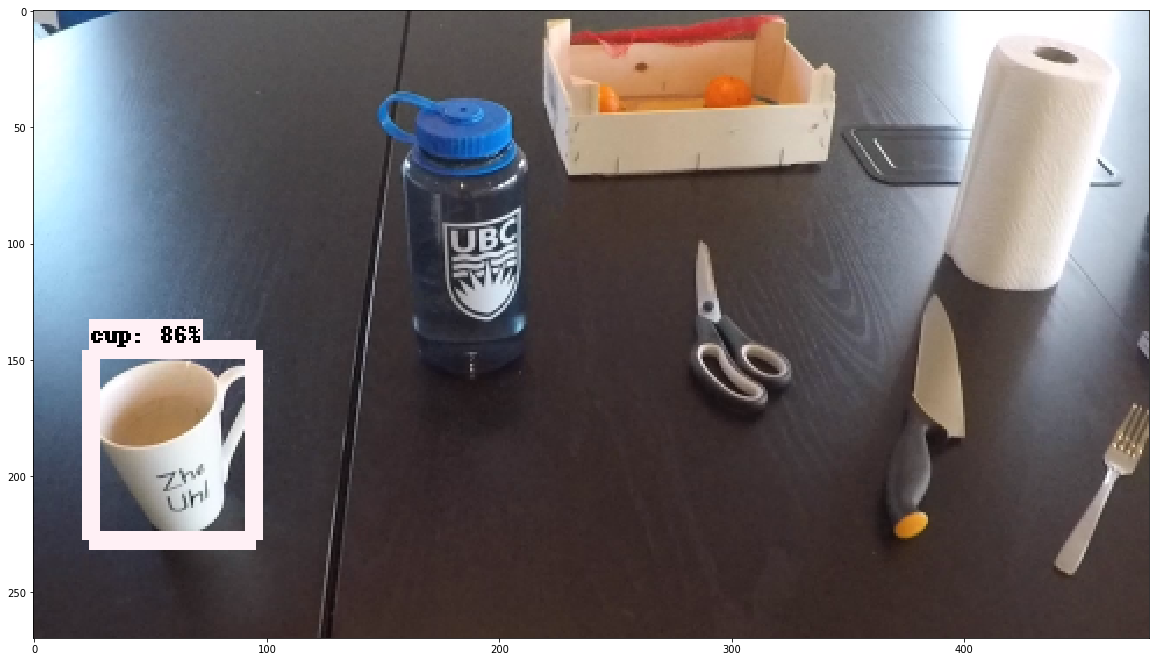

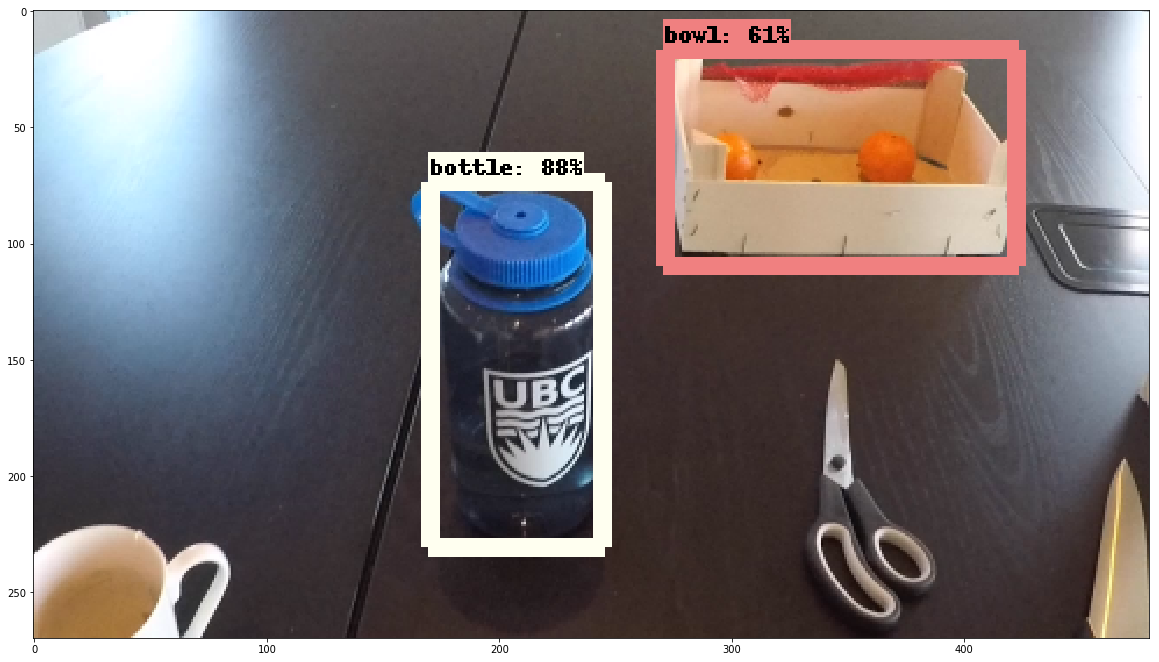

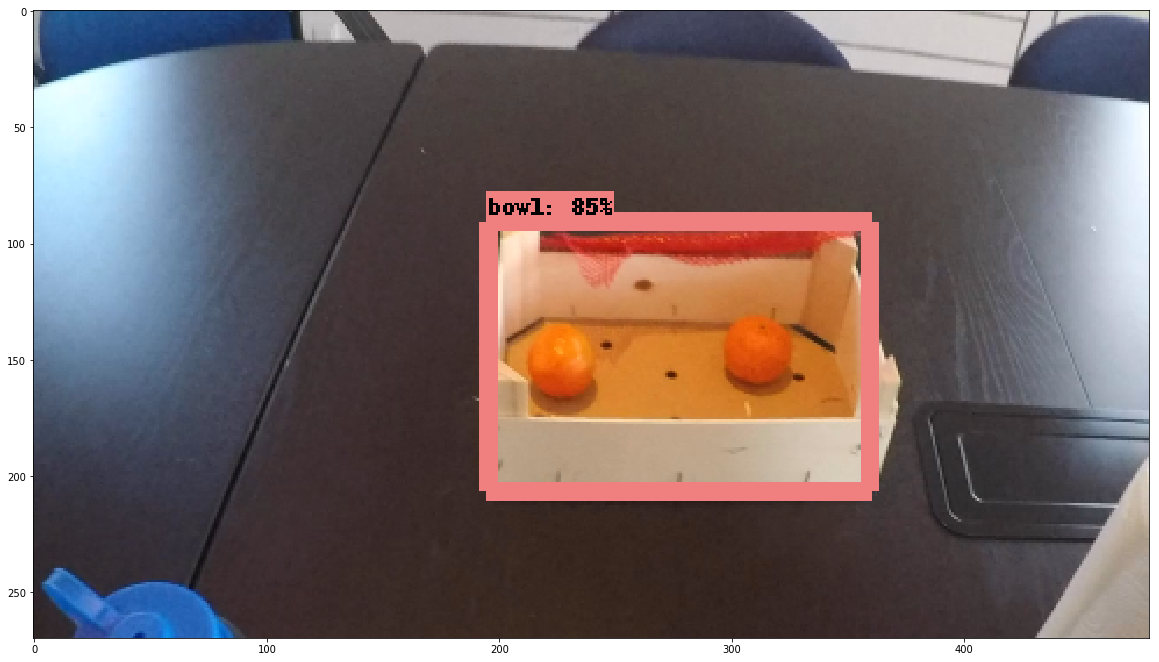

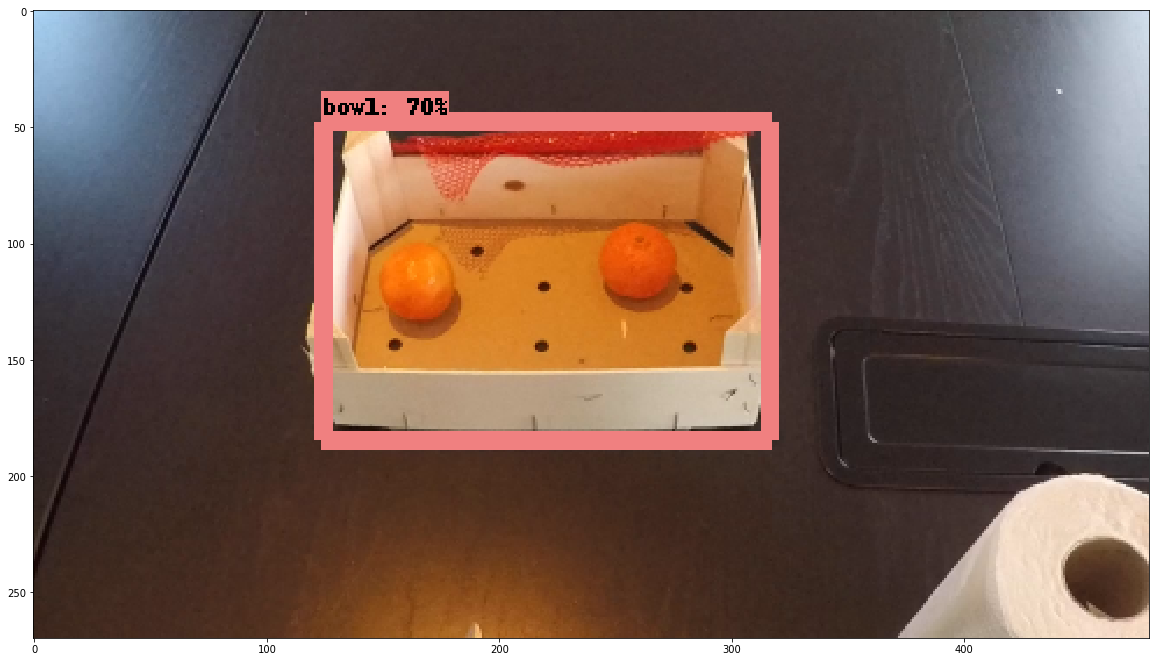

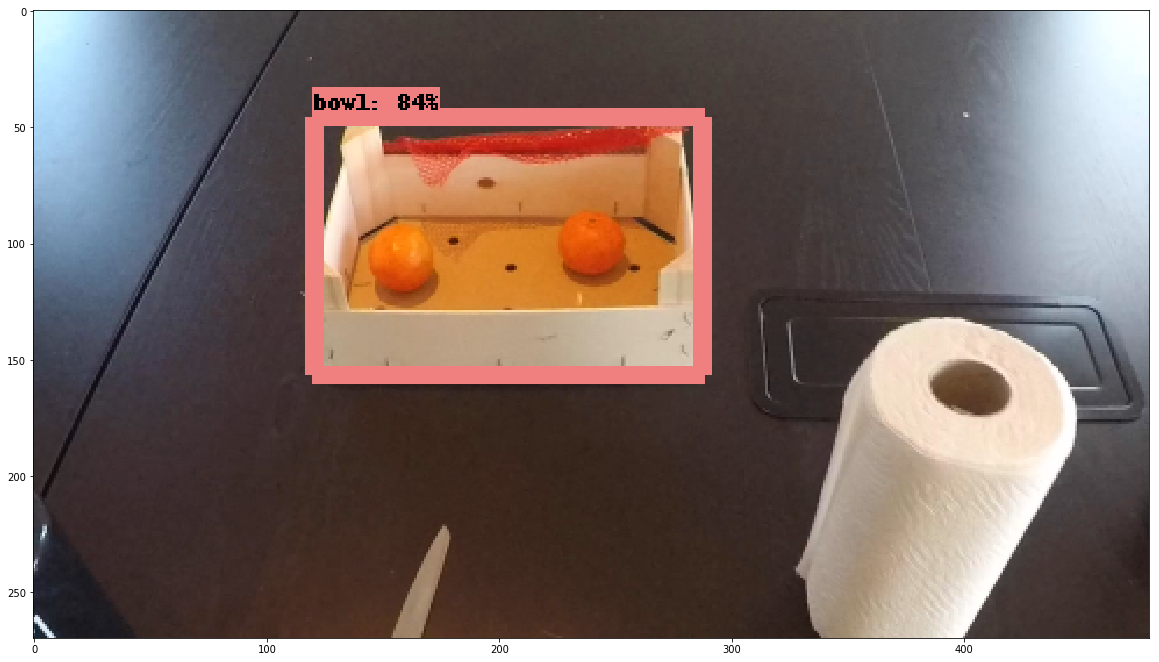

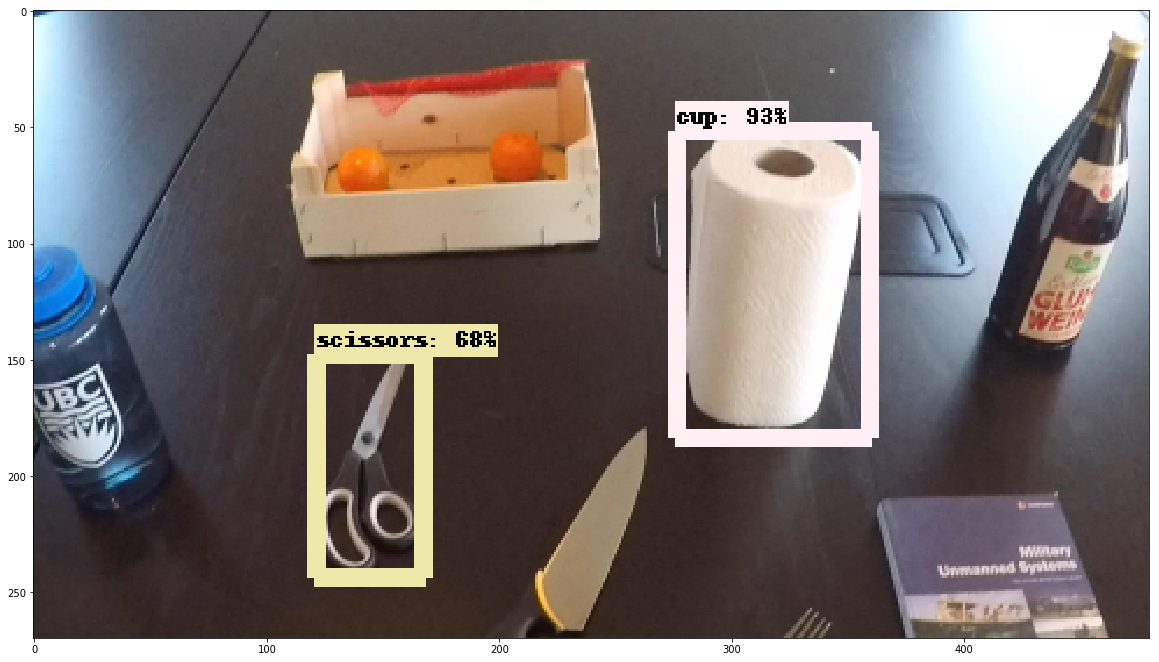

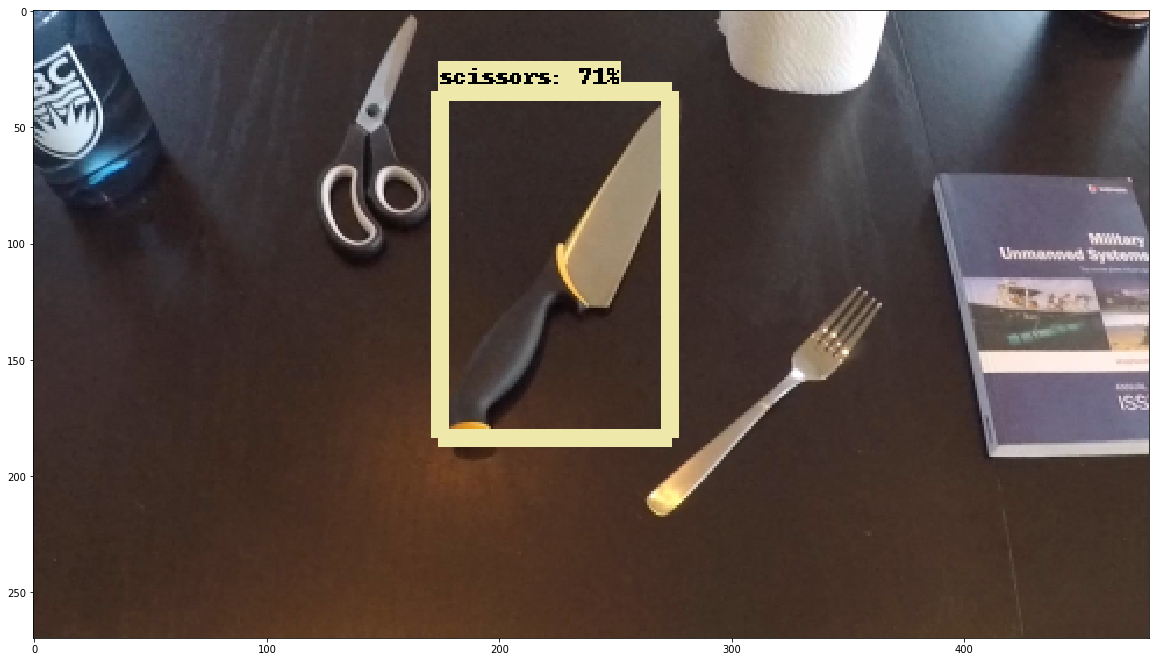

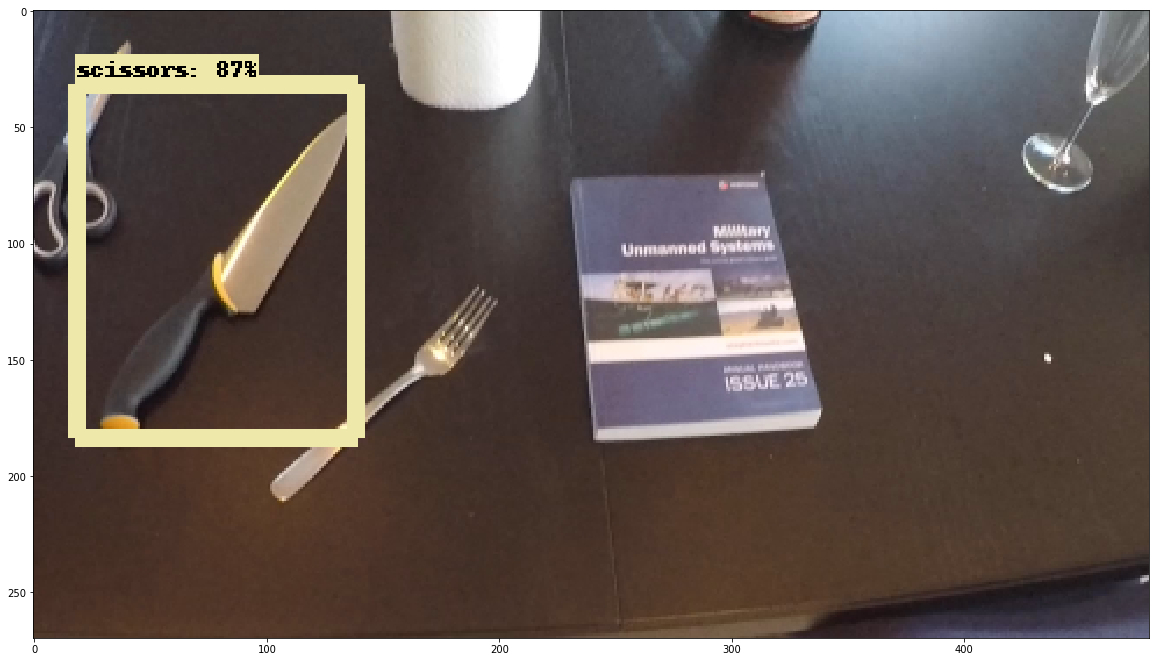

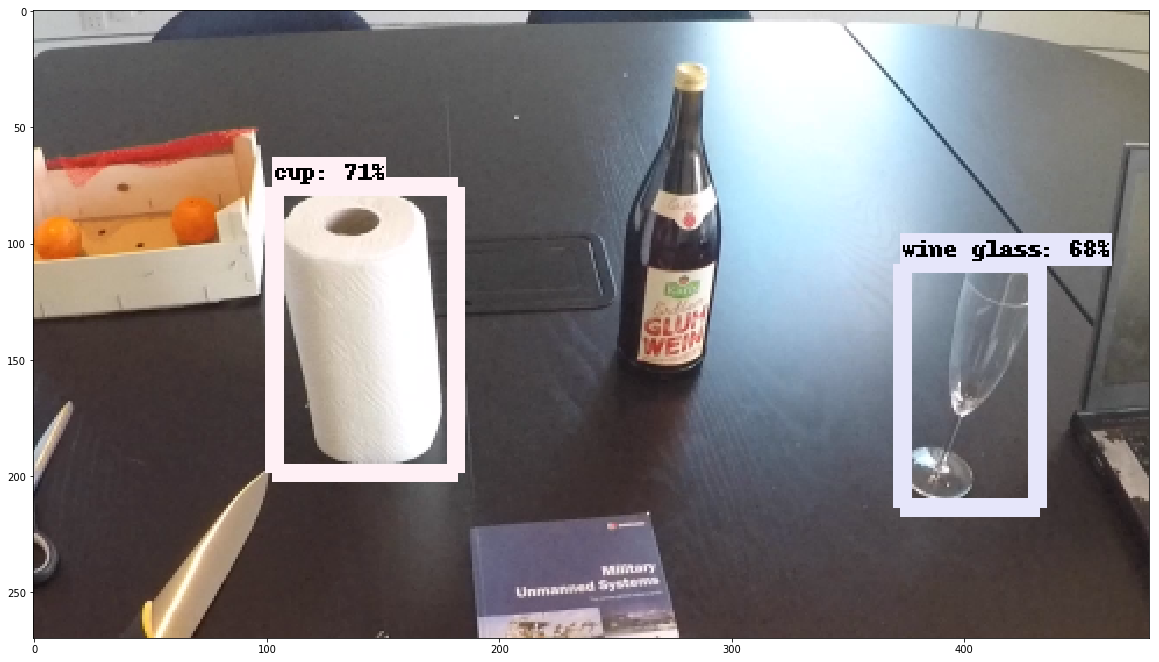

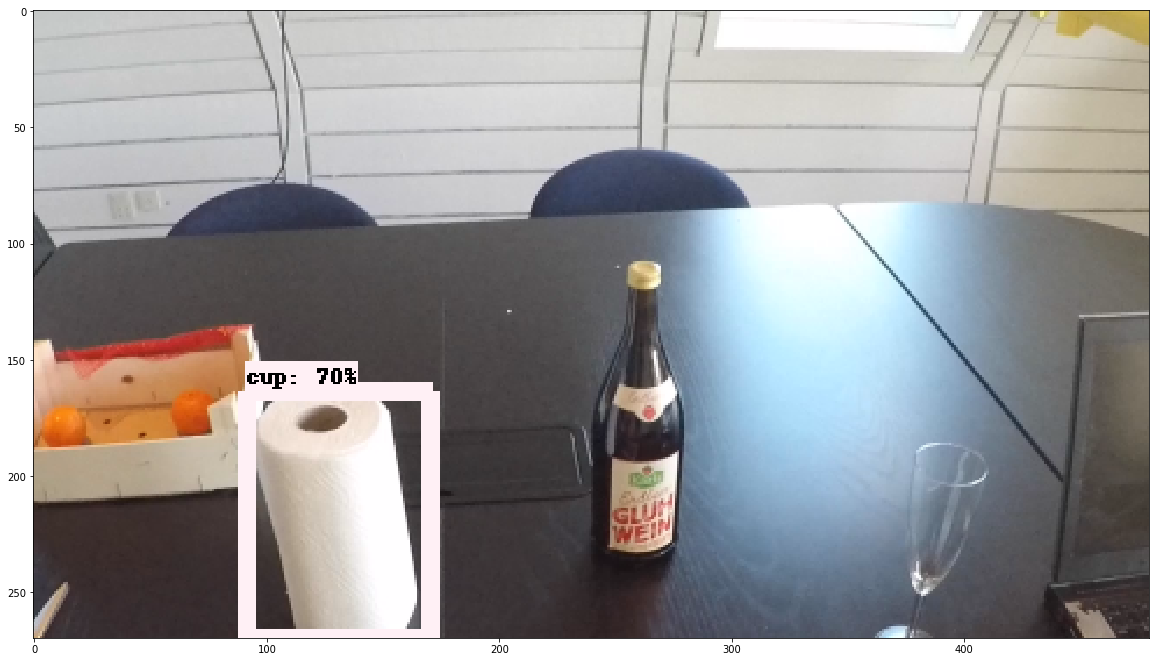

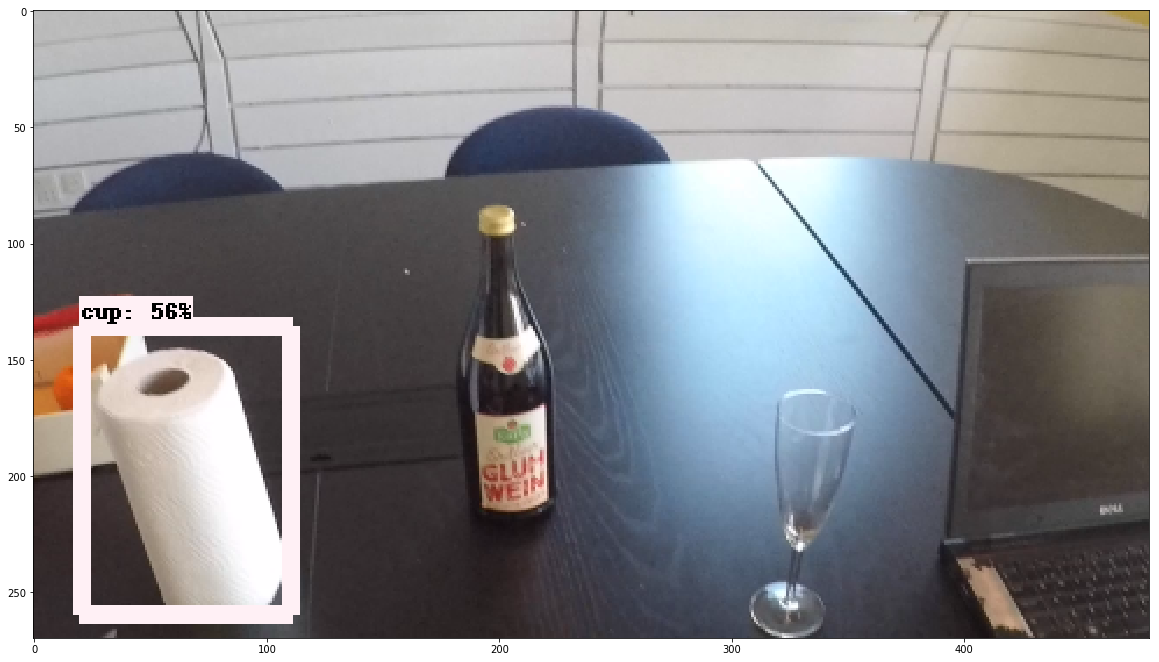

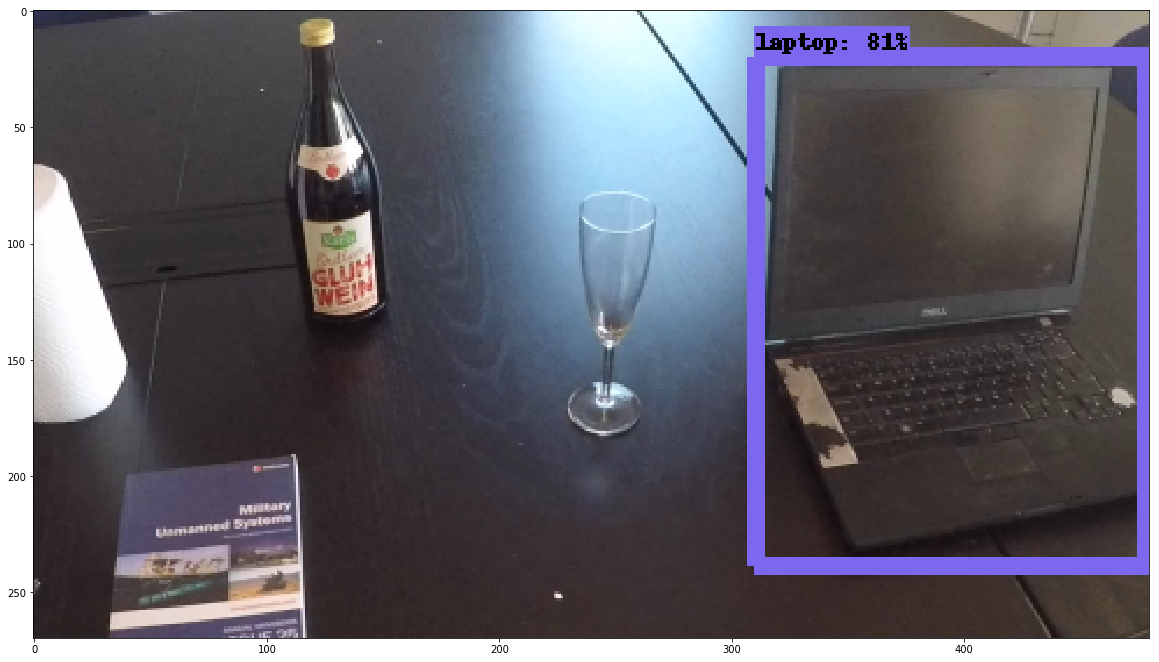

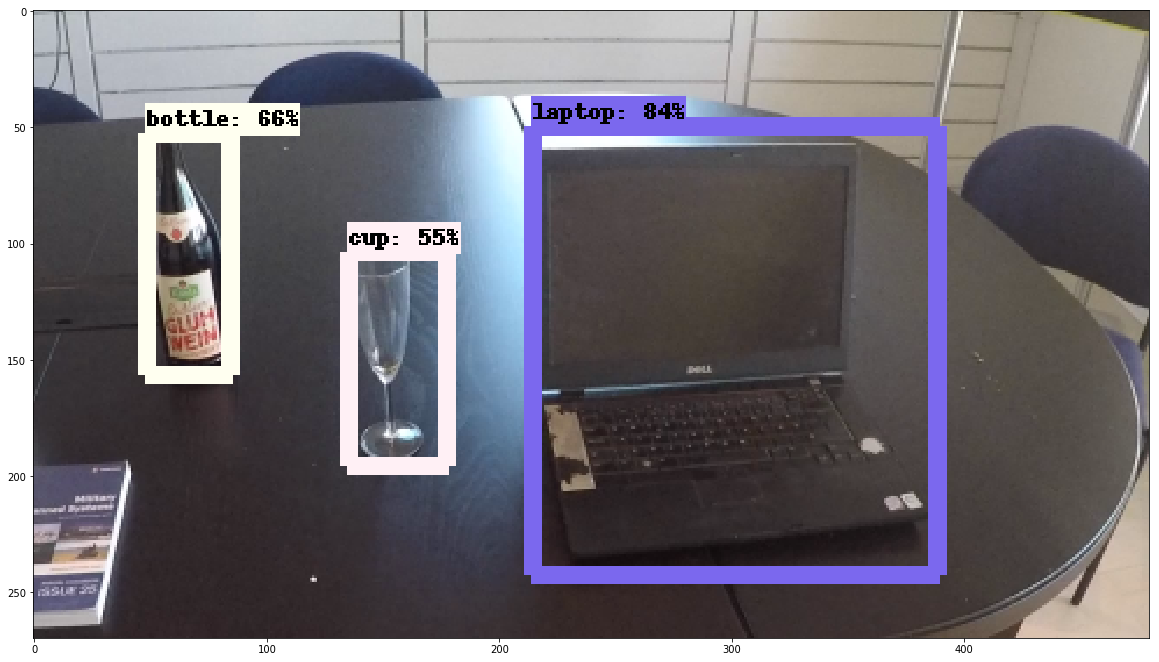

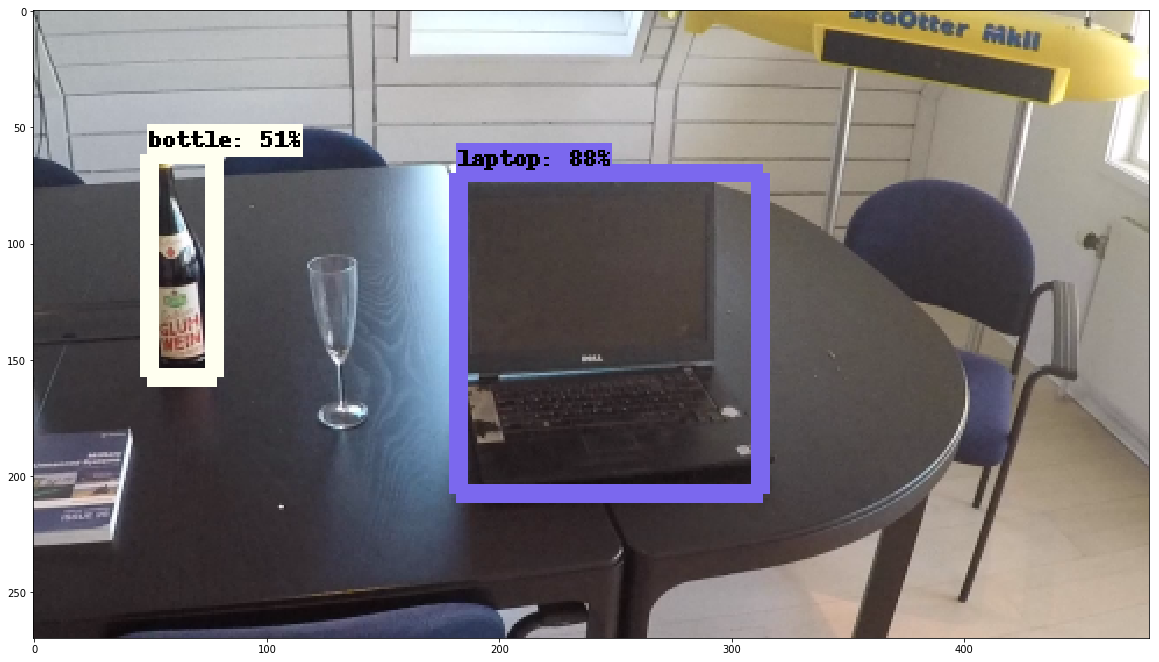

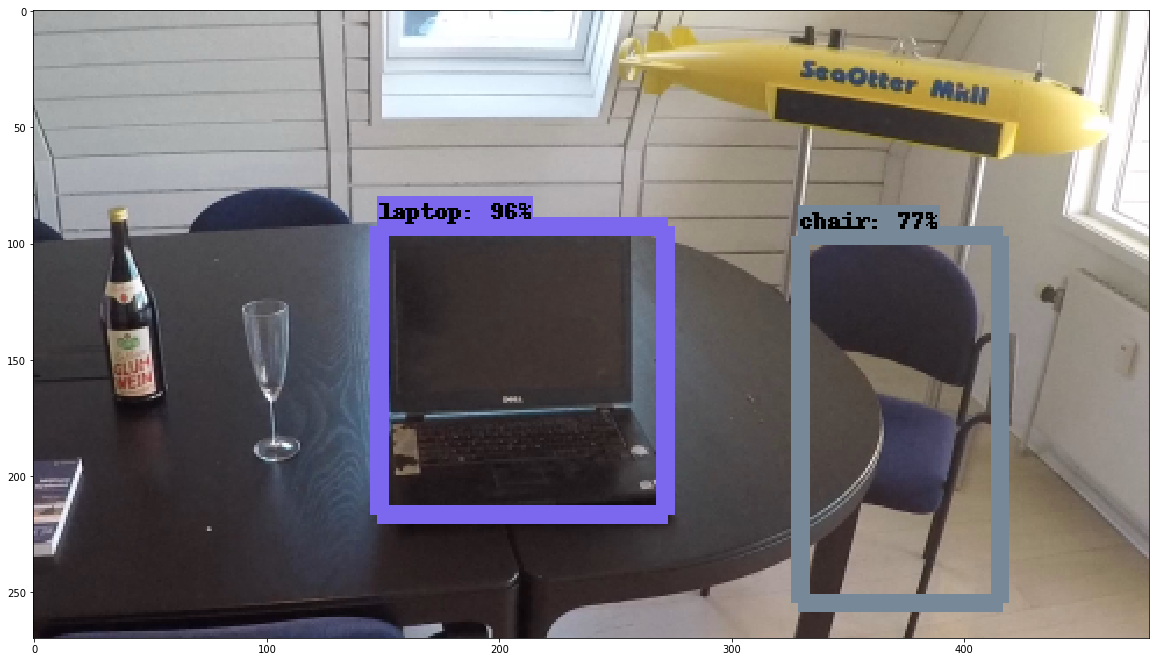

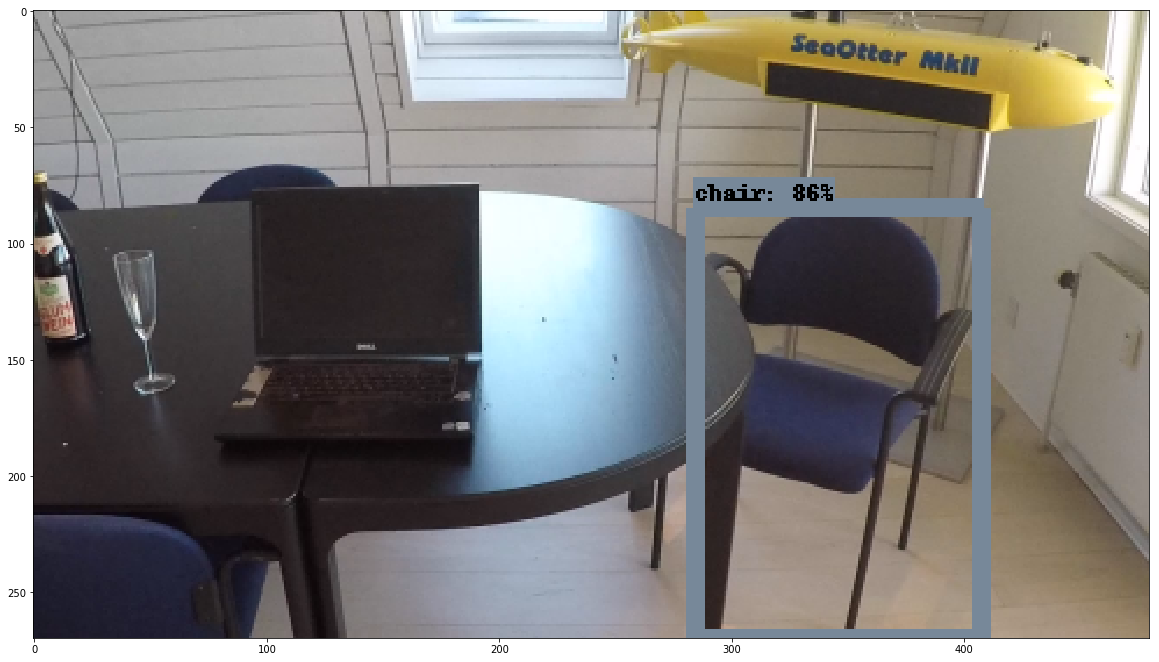

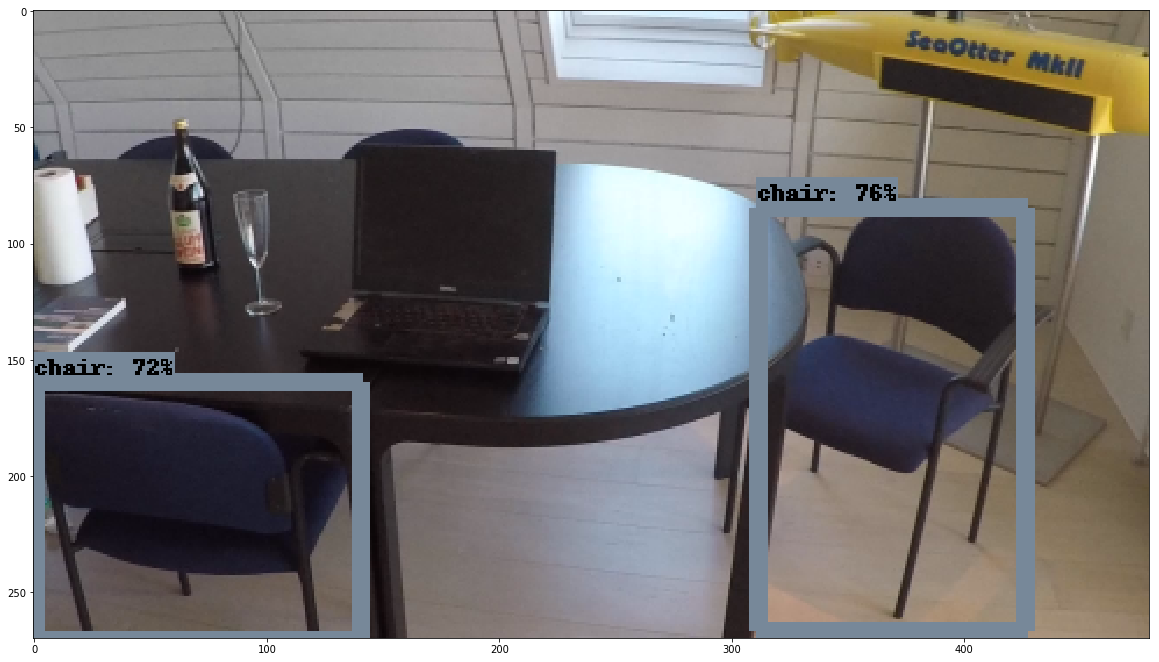

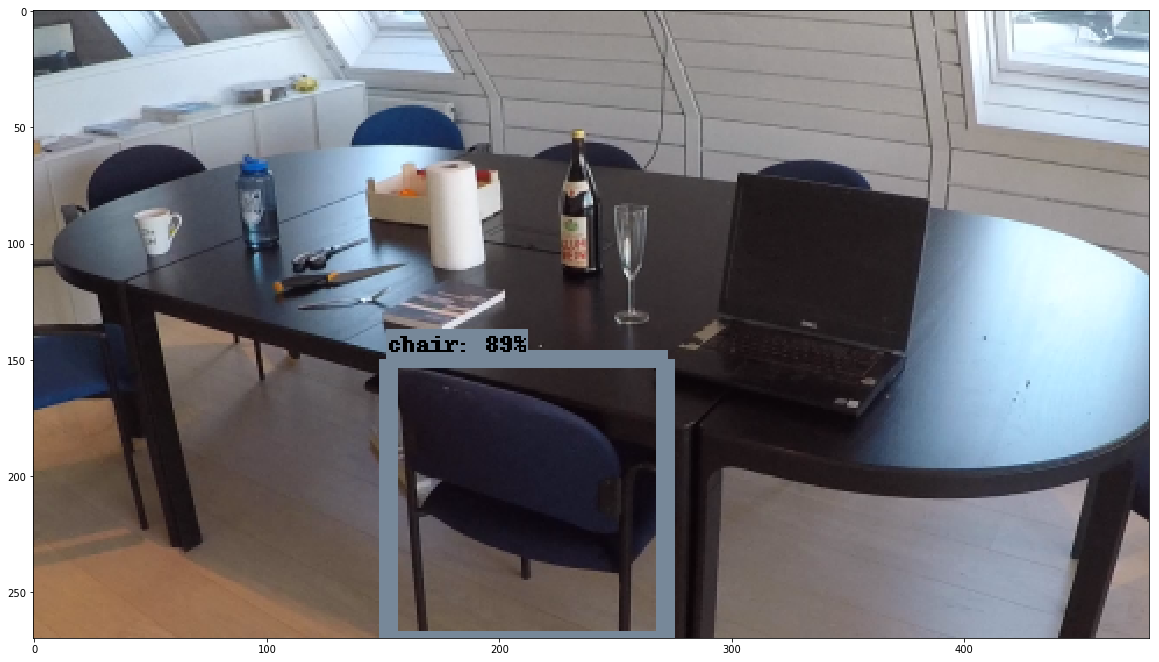

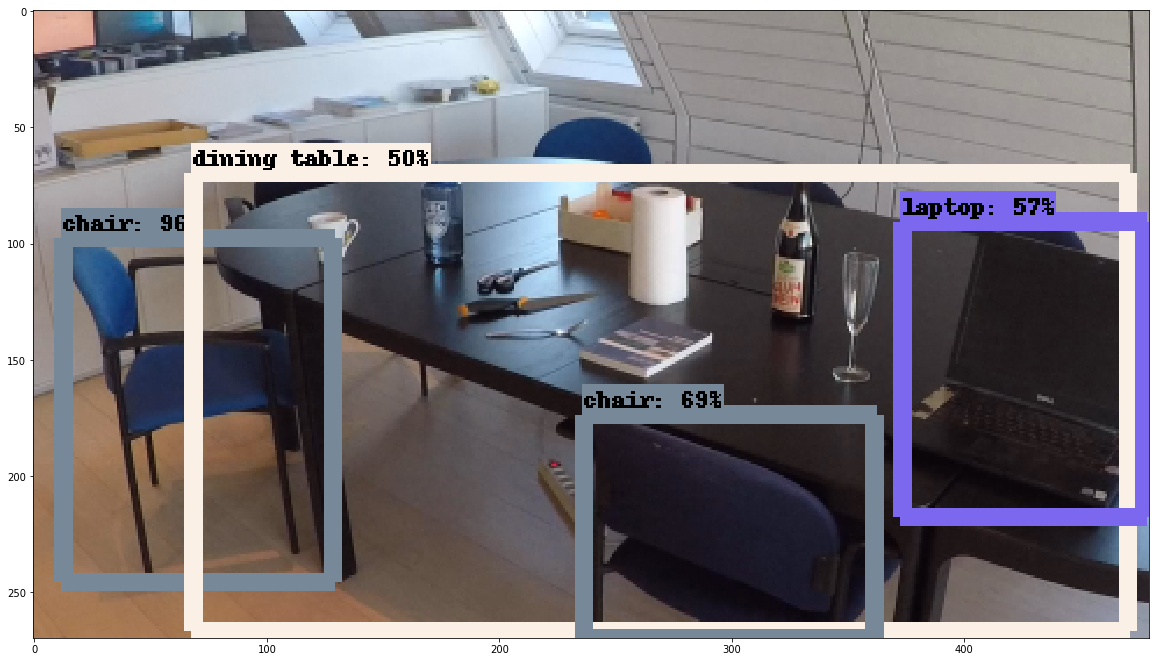

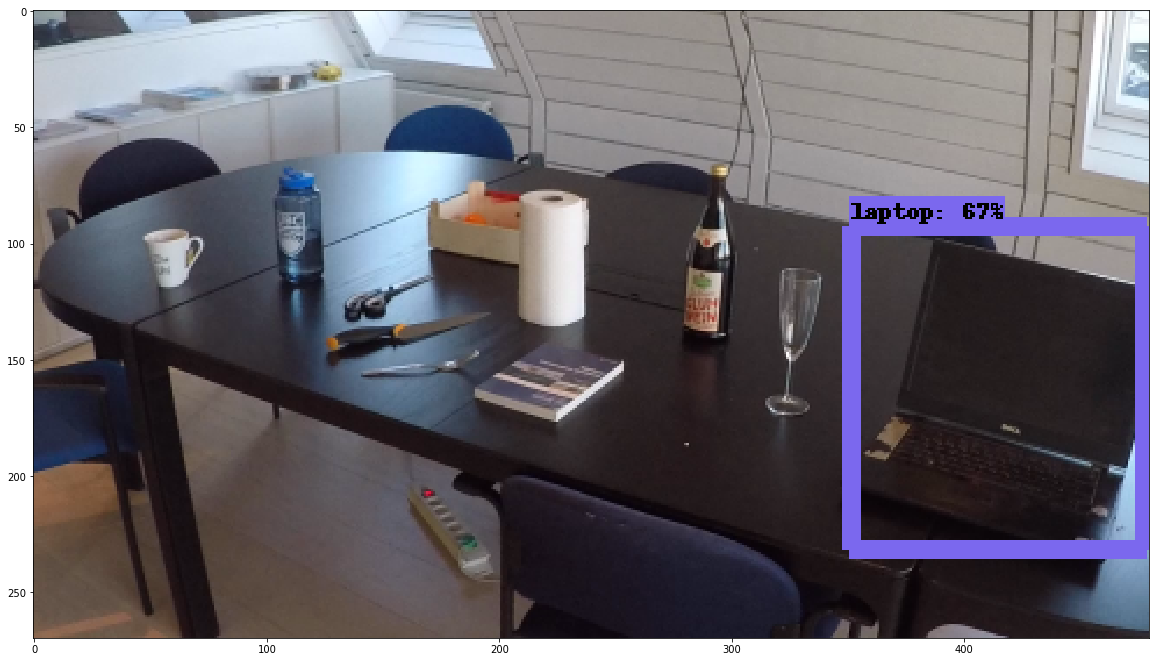

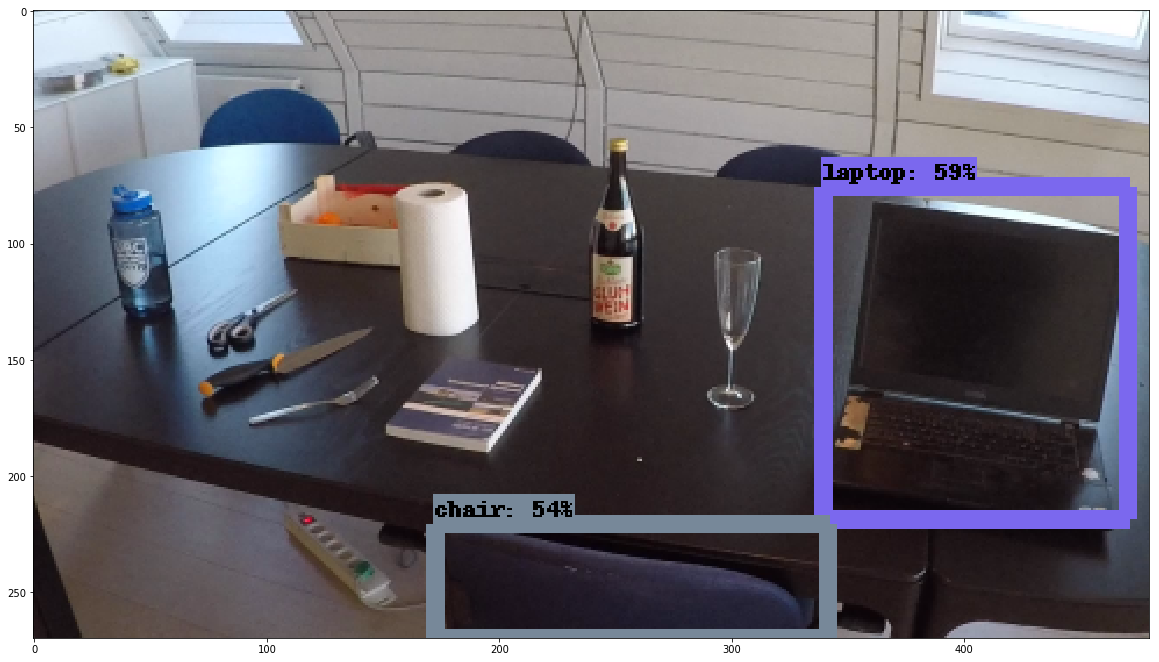

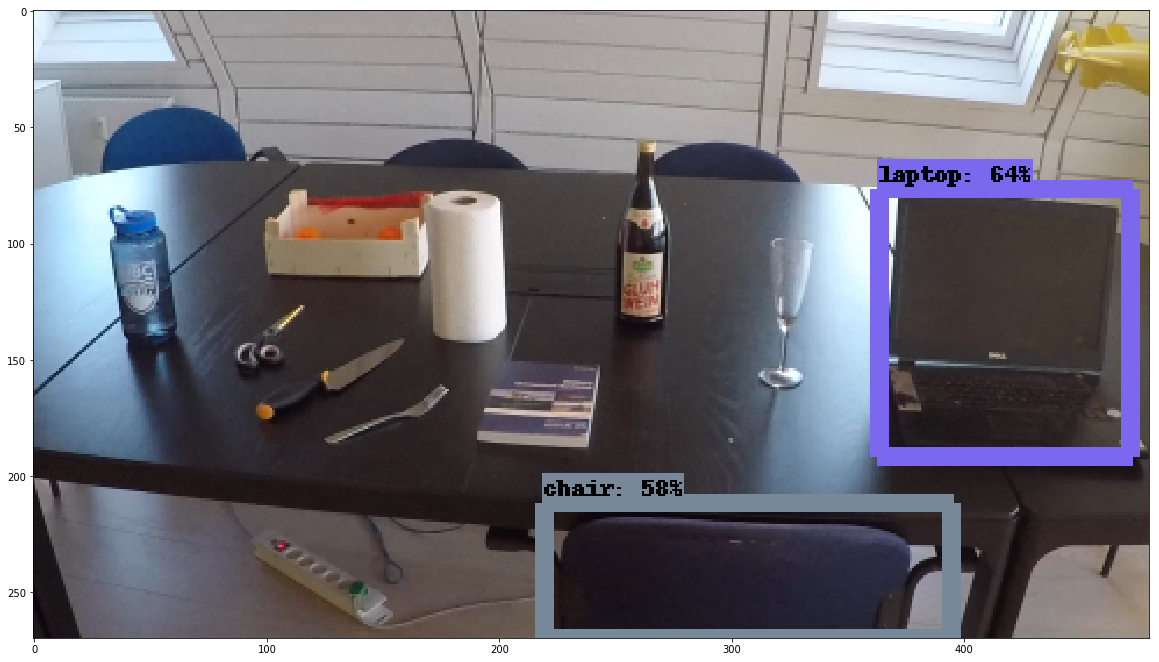

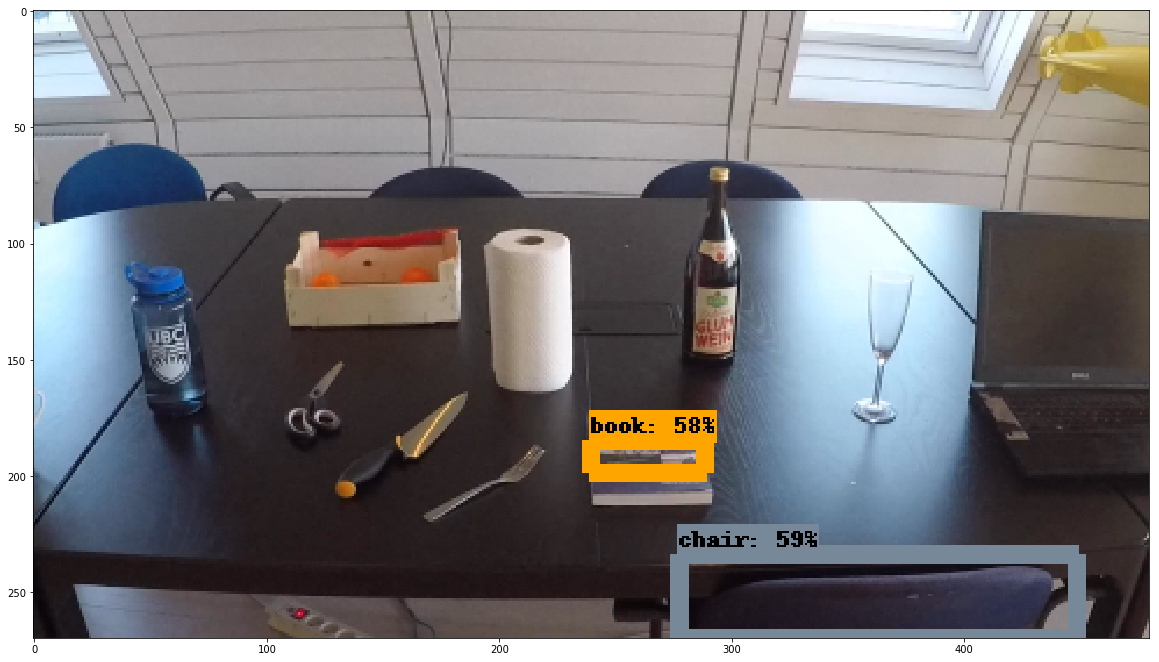

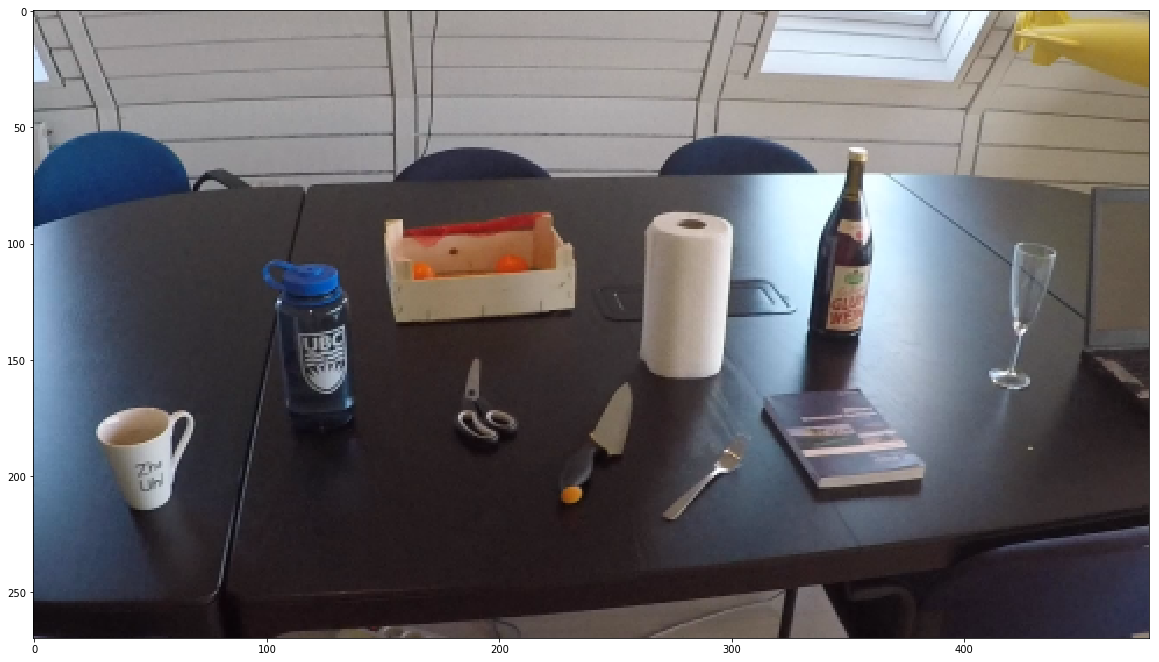

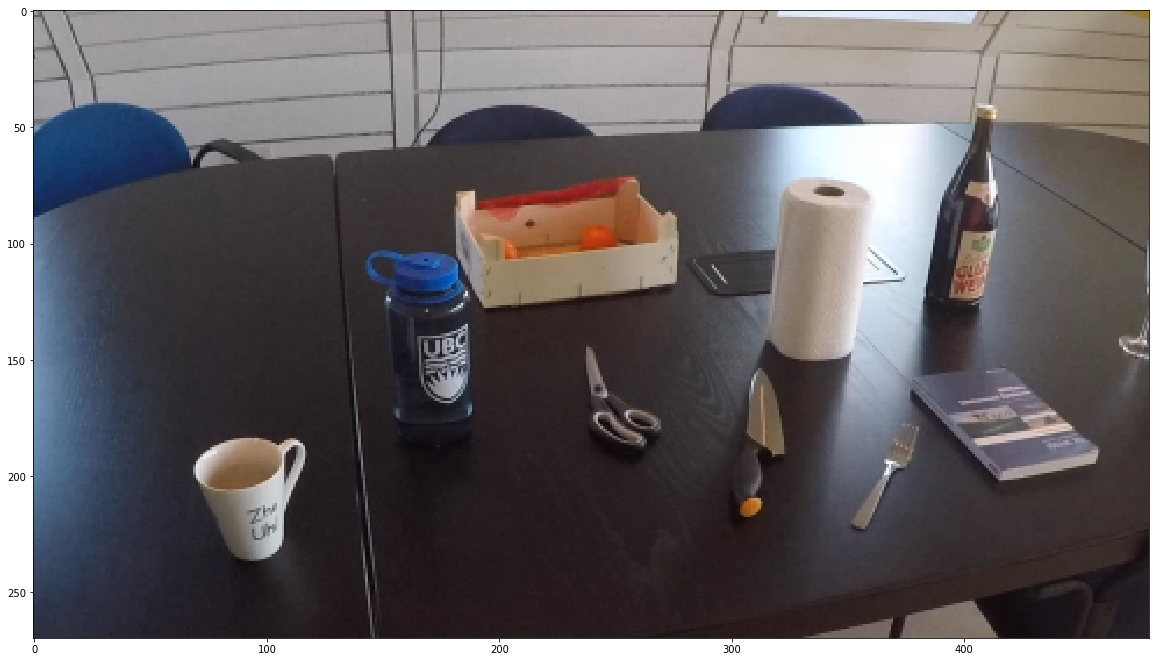

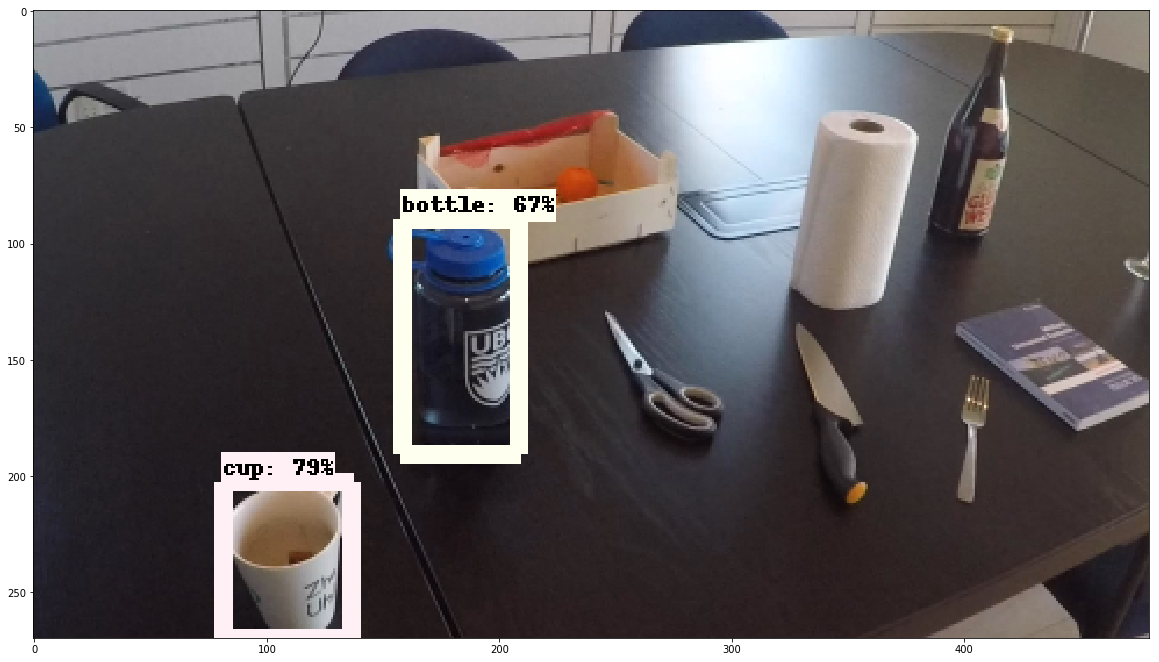

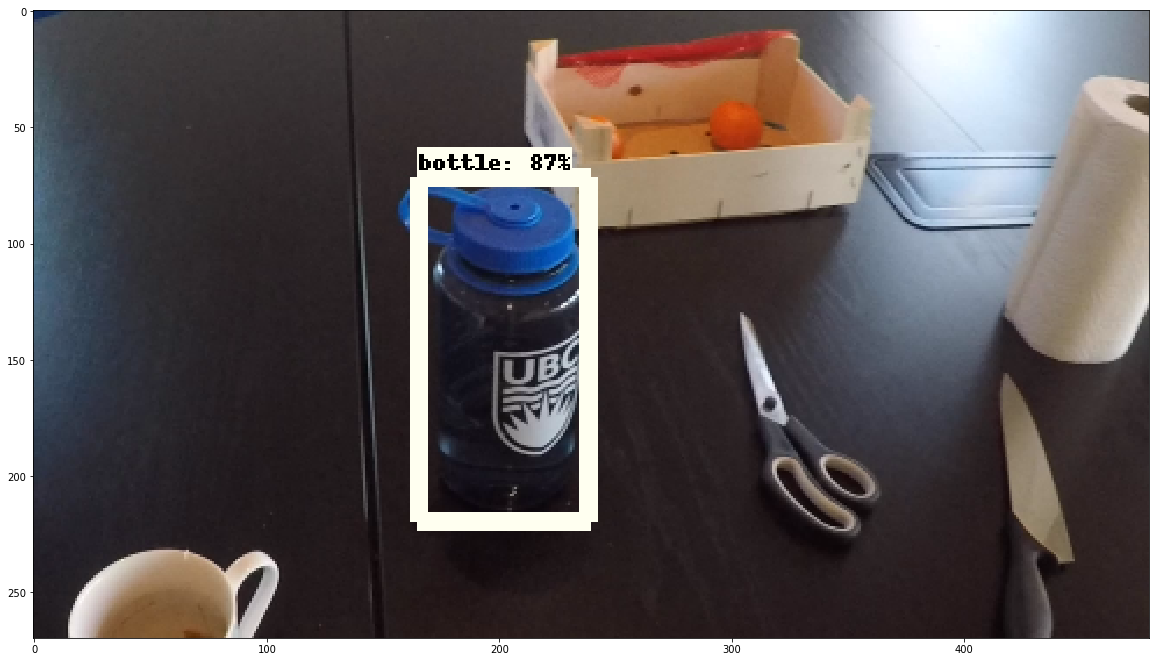

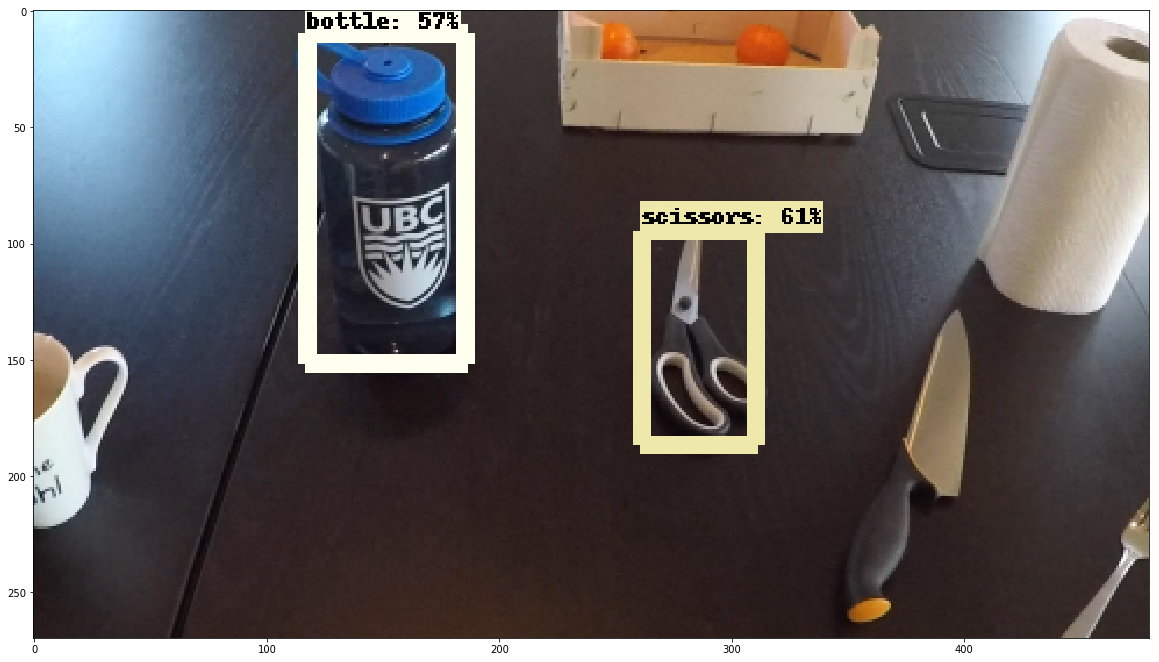

[INFO] elapsed time (total): 368.55
[INFO] approx. FPS: 2.47


In [12]:
num_workers = 1
num_queue = 5

#logger = multiprocessing.log_to_stderr()
#logger.setLevel(multiprocessing.SUBDEBUG)

input_q = Queue(maxsize=num_queue)
output_q = Queue(maxsize=num_queue)
pool = Pool(num_workers, worker, (input_q, output_q))

print("[INFO] starting video file thread...")
video_capture = FileVideoStream("../data/test_video.mp4").start()

time.sleep(1.0)
#video_capture = WebcamVideoStream(src=0,width=480,height=360).start()
fps = FPS().start()
framecnt = 0
while video_capture.more():  # fps._numFrames < 120
    frame = video_capture.read()
    framecnt = framecnt + 1
    frame = imutils.resize(frame, width=480)
    input_q.put(frame)

    t = time.time()

    output_rgb = output_q.get()
    #output_rgb = cv2.cvtColor(output_q.get(), cv2.COLOR_RGB2BGR)
    #cv2.imshow('Video', output_rgb)
    #clear_output(wait=True)
    #plt.imshow(output_rgb)
    #plt.show()
    
    if framecnt % 30 == 0:
        #clear_output(wait=True)
        plt.figure(figsize=(20, 15))
        plt.imshow(output_rgb)
        plt.show()
    
    fps.update()

    #print('[INFO] elapsed time: {:.2f}'.format(time.time() - t))

    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

fps.stop()
print('[INFO] elapsed time (total): {:.2f}'.format(fps.elapsed()))
print('[INFO] approx. FPS: {:.2f}'.format(fps.fps()))

pool.terminate()
video_capture.stop()
#cv2.destroyAllWindows()